In [ ]:
import zipfile
from pathlib import Path

import cdsapi
from huggingface_hub import hf_hub_download

# Data will be downloaded here.
download_path = Path("~/downloads/cams")

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# Download the static variables from HuggingFace.
static_path = hf_hub_download(
    repo_id="microsoft/aurora",
    filename="aurora-0.4-air-pollution-static.pickle",
    local_dir="~/downloads/cams"
)
print("Static variables downloaded!")

# Download the surface-level variables.
if not (download_path / "2022-06-11-cams.nc.zip").exists():
    c = cdsapi.Client()
    c.retrieve(
        "cams-global-atmospheric-composition-forecasts",
        {
            "type": "forecast",
            "leadtime_hour": "0",
            "variable": [
                # Meteorological surface-level variables:
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "2m_temperature",
                "mean_sea_level_pressure",
                # Pollution surface-level variables:
                "particulate_matter_1um",
                "particulate_matter_2.5um",
                "particulate_matter_10um",
                "total_column_carbon_monoxide",
                "total_column_nitrogen_monoxide",
                "total_column_nitrogen_dioxide",
                "total_column_ozone",
                "total_column_sulphur_dioxide",
                # Meteorological atmospheric variables:
                "u_component_of_wind",
                "v_component_of_wind",
                "temperature",
                "geopotential",
                "specific_humidity",
                # Pollution atmospheric variables:
                "carbon_monoxide",
                "nitrogen_dioxide",
                "nitrogen_monoxide",
                "ozone",
                "sulphur_dioxide",
            ],
            "pressure_level": [
                "50",
                "100",
                "150",
                "200",
                "250",
                "300",
                "400",
                "500",
                "600",
                "700",
                "850",
                "925",
                "1000",
            ],
            "date": "2022-06-11",
            "time": ["00:00", "12:00"],
            "format": "netcdf_zip",
        },
        str(download_path / "2022-06-11-cams.nc.zip"),
    )
# Unpack the ZIP. It should contain the surface-level and atmospheric data in separate
# files.
if not (download_path / "2022-06-11-cams-surface-level.nc").exists():
    with zipfile.ZipFile(download_path / "2022-06-11-cams.nc.zip", "r") as zf, open(
        download_path / "2022-06-11-cams-surface-level.nc", "wb"
    ) as f:
        f.write(zf.read("data_sfc.nc"))
if not (download_path / "2022-06-11-cams-atmospheric.nc").exists():
    with zipfile.ZipFile(download_path / "2022-06-11-cams.nc.zip", "r") as zf, open(
        download_path / "2022-06-11-cams-atmospheric.nc", "wb"
    ) as f:
        f.write(zf.read("data_plev.nc"))
print("Surface-level and atmospheric variables downloaded!")

In [ ]:
import pickle

import torch
import xarray as xr

from aurora import Batch, Metadata
from aurora import AuroraAirPollution, rollout
from huggingface_hub import hf_hub_download
from pathlib import Path
import gc

# --- load statics ---
download_path = Path("~/downloads/cams").expanduser()
static_path = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")
with open(static_path, "rb") as f:
    static_vars = pickle.load(f)
surf_vars_ds = xr.open_dataset(
    download_path / "2022-06-11-cams-surface-level.nc", engine="netcdf4", decode_timedelta=True
)
atmos_vars_ds = xr.open_dataset(
    download_path / "2022-06-11-cams-atmospheric.nc", engine="netcdf4", decode_timedelta=True
)

# Select the zero-hour forecast to get the analysis product.
surf_vars_ds = surf_vars_ds.isel(forecast_period=0)
atmos_vars_ds = atmos_vars_ds.isel(forecast_period=0)

# The file has two time points: UTC 00 and UTC 12. We use both to construct the batch
# with time 2022-06-11 UTC 12.

batch = Batch(
    surf_vars={
        # `[None]` inserts a batch dimension of size one.
        "2t": torch.from_numpy(surf_vars_ds["t2m"].values[None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[None]),
        "pm1": torch.from_numpy(surf_vars_ds["pm1"].values[None]),
        "pm2p5": torch.from_numpy(surf_vars_ds["pm2p5"].values[None]),
        "pm10": torch.from_numpy(surf_vars_ds["pm10"].values[None]),
        "tcco": torch.from_numpy(surf_vars_ds["tcco"].values[None]),
        "tc_no": torch.from_numpy(surf_vars_ds["tc_no"].values[None]),
        "tcno2": torch.from_numpy(surf_vars_ds["tcno2"].values[None]),
        "gtco3": torch.from_numpy(surf_vars_ds["gtco3"].values[None]),
        "tcso2": torch.from_numpy(surf_vars_ds["tcso2"].values[None]),
    },
    static_vars={k: torch.from_numpy(v) for k, v in static_vars.items()},
    atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[None]),
        "co": torch.from_numpy(atmos_vars_ds["co"].values[None]),
        "no": torch.from_numpy(atmos_vars_ds["no"].values[None]),
        "no2": torch.from_numpy(atmos_vars_ds["no2"].values[None]),
        "go3": torch.from_numpy(atmos_vars_ds["go3"].values[None]),
        "so2": torch.from_numpy(atmos_vars_ds["so2"].values[None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(atmos_vars_ds.latitude.values),
        lon=torch.from_numpy(atmos_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s.
        time=(atmos_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[-1],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)


model = AuroraAirPollution()
model.load_checkpoint("microsoft/aurora", "aurora-0.4-air-pollution.ckpt")

model.eval()
model = model.to("cpu")

with torch.inference_mode():
    predictions = model(batch)
    # predictions = [pred.to("cpu") for pred in rollout(model, batch, steps=4)]

# model = model.to("cpu")

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 7))

for i in range(4):
    ax = axs[i // 2, i % 2]
    pred = predictions[i]
    ax.imshow(pred.surf_vars["tcno2"][0, 0].numpy() / 1e-6, vmin=0, vmax=10, cmap="Blues")
    ax.set_title(f"TC NO${{}}_2$ {pred.metadata.time[0]}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

fig, axs = plt.subplots(2, 2, figsize=(12, 7))

for i in range(4):
    ax = axs[i // 2, i % 2]
    pred = predictions[i]
    ax.imshow(pred.surf_vars["pm10"][0, 0].numpy() / 1e-9, vmin=0, vmax=400, cmap="Blues")
    ax.set_title(f"PM${{}}_{{10}}$ {pred.metadata.time[0]}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

In [ ]:
import pickle, torch, xarray as xr, numpy as np, gc
from aurora import Batch, Metadata, AuroraAirPollution, rollout
from huggingface_hub import hf_hub_download
from pathlib import Path

# --- load statics ---
download_path = Path("~/downloads/cams").expanduser()
static_path = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")
with open(static_path, "rb") as f:
    static_vars = pickle.load(f)

# --- open datasets (must contain 2 time steps for history) ---
surf_var_ds = xr.open_dataset(download_path / "2022-06-11-cams-surface-level.nc", engine="netcdf4", decode_timedelta=True)
atmos_vars_ds = xr.open_dataset(download_path / "2022-06-11-cams-atmospheric.nc",   engine="netcdf4", decode_timedelta=True)


surf_var_ds = surf_var_ds.isel(forecast_period=0)
atmos_vars_ds = atmos_vars_ds.isel(forecast_period=0)

# --- build model & get patch size AFTER loading checkpoint ---
model = AuroraAirPollution()
model.load_checkpoint("microsoft/aurora", "aurora-0.4-air-pollution.ckpt")
model.eval()
ps = int(model.patch_size)
print("model.patch_size =", ps)

# --- choose a safe spatial window (H,W are multiples of ps and >= 2*ps; 4*ps is safer) ---
H = W = 4 * ps
lat_len, lon_len = surf_var_ds.sizes["latitude"], surf_var_ds.sizes["longitude"]
H = min((lat_len // ps) * ps, H)
W = min((lon_len // ps) * ps, W)
if H < 2*ps or W < 2*ps:
    raise ValueError(f"Dataset too small for patch_size={ps}: choose smaller ps or use a different file.")

def center_start(total, window): return max(0, (total - window) // 2)
i0 = center_start(lat_len, H)
j0 = center_start(lon_len, W)

surf = surf_var_ds.isel(latitude=slice(i0, i0+H), longitude=slice(j0, j0+W))
atmo = atmos_vars_ds.isel(latitude=slice(i0, i0+H), longitude=slice(j0, j0+W))

# --- quick shape checks: we want time/history dimension = 2, spatial = HxW ---
print("surf t2m shape:", surf["t2m"].shape)     # (time=2, H, W) or (something,2,H,W) depending on file
print("atmo t shape:",  atmo["t"].shape)        # (time=2, level, H, W)

# --- subset static vars to same HxW ---
def subset_static(a):
    # static arrays are typically (H,W) or (C,H,W) or (C,lat,lon)
    if a.ndim == 3: return a[:, i0:i0+H, j0:j0+W]
    if a.ndim == 2: return a[i0:i0+H, j0:j0+W]
    return a
static_vars = {k: subset_static(v) for k, v in static_vars.items()}

# --- build Batch (each tensor: (B, T, H, W) or (B, T, L, H, W) for atmos) ---
# Add batch dim with [None]; time dimension must already be 2 in the data.
surf_vars = {
    "2t":   torch.from_numpy(surf["t2m"].values[None]),
    "10u":  torch.from_numpy(surf["u10"].values[None]),
    "10v":  torch.from_numpy(surf["v10"].values[None]),
    "msl":  torch.from_numpy(surf["msl"].values[None]),
    "pm1":  torch.from_numpy(surf["pm1"].values[None]),
    "pm2p5":torch.from_numpy(surf["pm2p5"].values[None]),
    "pm10": torch.from_numpy(surf["pm10"].values[None]),
    "tcco": torch.from_numpy(surf["tcco"].values[None]),
    "tc_no":torch.from_numpy(surf["tc_no"].values[None]),
    "tcno2":torch.from_numpy(surf["tcno2"].values[None]),
    "gtco3":torch.from_numpy(surf["gtco3"].values[None]),
    "tcso2":torch.from_numpy(surf["tcso2"].values[None]),
}
atmos_vars = {
    "t":   torch.from_numpy(atmo["t"].values[None]),   # (B, T, L, H, W)
    "u":   torch.from_numpy(atmo["u"].values[None]),
    "v":   torch.from_numpy(atmo["v"].values[None]),
    "q":   torch.from_numpy(atmo["q"].values[None]),
    "z":   torch.from_numpy(atmo["z"].values[None]),
    "co":  torch.from_numpy(atmo["co"].values[None]),
    "no":  torch.from_numpy(atmo["no"].values[None]),
    "no2": torch.from_numpy(atmo["no2"].values[None]),
    "go3": torch.from_numpy(atmo["go3"].values[None]),
    "so2": torch.from_numpy(atmo["so2"].values[None]),
}

# metadata expects (H,), (W,), time tuple, and levels tuple
lat_vec = torch.from_numpy(atmo.latitude.values)   # shape (H,)
lon_vec = torch.from_numpy(atmo.longitude.values)  # shape (W,)
time_tuple = tuple(atmo.valid_time.values.astype("datetime64[s]").astype(object))
levels_tuple = tuple(int(x) for x in atmo.pressure_level.values)

batch = Batch(
    surf_vars=surf_vars,
    static_vars={k: torch.from_numpy(v) for k, v in static_vars.items()},
    atmos_vars=atmos_vars,
    metadata=Metadata(
        lat=lat_vec,
        lon=lon_vec,
        time=time_tuple,          # length should be 2 (prev, current)
        atmos_levels=levels_tuple
    ),
)

# --- run 1-step rollout on CPU ---
gc.collect(); torch.cuda.empty_cache()
# one-step prediction without the rollout concat logic
with torch.inference_mode():
    # predictions = [p.to("cpu") for p in rollout(model, batch, steps=4)]
    predictions = model(batch)          # or: pred = model.forward(batch)



In [ ]:
# --- Aurora tiled global PM10 with feathered blending (CPU) ----------------
import pickle, gc
from pathlib import Path

import numpy as np
import torch
import xarray as xr
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

from aurora import Batch, Metadata, AuroraAirPollution

# ------------------ config / paths ------------------
download_path = Path("~/downloads/cams").expanduser()
surf_path = download_path / "2022-06-11-cams-surface-level.nc"
atmo_path = download_path / "2022-06-11-cams-atmospheric.nc"
static_path = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")

# ------------------ load static vars ------------------
with open(static_path, "rb") as f:
    static_vars_full = pickle.load(f)

# ------------------ open datasets ------------------
surf_ds = xr.open_dataset(surf_path, engine="netcdf4", decode_timedelta=True)
atmo_ds = xr.open_dataset(atmo_path, engine="netcdf4", decode_timedelta=True)
print("Surface dataset variables:", list(surf_ds.data_vars))
print("Atmospheric dataset variables:", list(atmo_ds.data_vars))


print("before forecast period selection:")
print("Surface dataset dims:", surf_ds.dims)
print("Atmospheric dataset dims:", atmo_ds.dims)
print("Surface dataset sizes:", surf_ds.sizes)
print("Atmospheric dataset sizes:", atmo_ds.sizes)
print("Surface dataset coords:", list(surf_ds.coords))
print("Atmospheric dataset coords:", list(atmo_ds.coords))
print(f"surf_ds.longitude.shape: {surf_ds.longitude.shape}, surf_ds.latitude.shape: {surf_ds.latitude.shape}")
print(f"atmo_ds.longitude.shape: {atmo_ds.longitude.shape}, atmo_ds.latitude.shape: {atmo_ds.latitude.shape}")


# use analysis product; keep both time steps (00Z, 12Z)
print("after forecast period selection:")
if "forecast_period" in surf_ds.dims: surf_ds = surf_ds.isel(forecast_period=0)
if "forecast_period" in atmo_ds.dims: atmo_ds = atmo_ds.isel(forecast_period=0)
print("Surface dataset dims:", surf_ds.dims)
print("Atmospheric dataset dims:", atmo_ds.dims)
print("Surface dataset sizes:", surf_ds.sizes)
print("Atmospheric dataset sizes:", atmo_ds.sizes)
print("Surface dataset coords:", list(surf_ds.coords))
print("Atmospheric dataset coords:", list(atmo_ds.coords))
print(f"surf_ds.longitude.shape: {surf_ds.longitude.shape}, surf_ds.latitude.shape: {surf_ds.latitude.shape}")
print(f"atmo_ds.longitude.shape: {atmo_ds.longitude.shape}, atmo_ds.latitude.shape: {atmo_ds.latitude.shape}")



# ------------------ build model ------------------
model = AuroraAirPollution()
model.load_checkpoint("microsoft/aurora", "aurora-0.4-air-pollution.ckpt")
model.eval()
ps = int(model.patch_size)
print("patch_size:", ps)

# ------------------ sizes & crop to multiples of patch size ------------------
lat_len = surf_ds.sizes["latitude"]
lon_len = surf_ds.sizes["longitude"]
H = (lat_len // ps) * ps
W = (lon_len // ps) * ps
print(f"Original dataset size (HxW): {lat_len} x {lon_len}")
print(f"Global working size (HxW): {H} x {W}")

print(f"before cropping surf_ds.latitude.shape: {surf_ds.latitude.shape}, surf_ds.longitude.shape: {surf_ds.longitude.shape}")
surf_ds = surf_ds.isel(latitude=slice(0, H), longitude=slice(0, W))
atmo_ds = atmo_ds.isel(latitude=slice(0, H), longitude=slice(0, W))
print(f"after cropping surf_ds.latitude.shape: {surf_ds.latitude.shape}, surf_ds.longitude.shape: {surf_ds.longitude.shape}")

lat_vec_full = atmo_ds.latitude.values
lon_vec_full = atmo_ds.longitude.values
print("lat_vec_full.shape:", lat_vec_full.shape)
print("lon_vec_full.shape:", lon_vec_full.shape)

# ------------------ tiling parameters ------------------
tile   = 12 * ps         # tile height/width
overlap = 2 * ps         # a bit more overlap blends better than ps
step   = tile - overlap  # stride

# weighted accumulation buffers
accum = np.zeros((H, W), dtype=np.float32)
wsum  = np.zeros((H, W), dtype=np.float32)

def subset_static_tile(arr, ii, jj):
    if arr.ndim == 3:  # (C,H,W)
        return arr[:, ii, jj]
    if arr.ndim == 2:  # (H,W)
        return arr[ii, jj]
    return arr

def hann_blend(h, w, edge):
    """2D separable raised-cosine feather that decays to 0 within 'edge' of borders."""
    edge = max(1, int(edge))
    def _ramp(n):
        r = np.ones(n, dtype=np.float32)
        # left
        wl = min(edge, n)
        if wl > 0:
            x = np.linspace(0, np.pi, wl, dtype=np.float32)
            r[:wl] = 0.5 - 0.5*np.cos(x)
        # right
        wr = min(edge, n)
        if wr > 0:
            x = np.linspace(np.pi, 0, wr, dtype=np.float32)
            r[-wr:] = 0.5 - 0.5*np.cos(x)
        return r
    ry = _ramp(h)
    rx = _ramp(w)
    return np.outer(ry, rx)

# ------------------ run tiled inference with blending ------------------
gc.collect(); torch.cuda.empty_cache()

for i in range(0, H, step):
    for j in range(0, W, step):
        hi = min(i + tile, H)
        wi = min(j + tile, W)
        # force each side to be a multiple of ps
        h = (hi - i) // ps * ps
        w = (wi - j) // ps * ps
        if h < ps or w < ps:
            continue
        ii = slice(i, i + h)
        jj = slice(j, j + w)

        # tile-specific blending mask (feather edge ~ half the overlap)
        weight = hann_blend(h, w, edge=overlap//2)

        # build tile datasets
        surf_t = surf_ds.isel(latitude=ii, longitude=jj)
        atmo_t = atmo_ds.isel(latitude=ii, longitude=jj)
        static_vars_tile = {k: subset_static_tile(v, ii, jj) for k, v in static_vars_full.items()}

        surf_vars = {
            "2t":    torch.from_numpy(surf_t["t2m" ].values[None]),
            "10u":   torch.from_numpy(surf_t["u10" ].values[None]),
            "10v":   torch.from_numpy(surf_t["v10" ].values[None]),
            "msl":   torch.from_numpy(surf_t["msl" ].values[None]),
            "pm1":   torch.from_numpy(surf_t["pm1" ].values[None]),
            "pm2p5": torch.from_numpy(surf_t["pm2p5"].values[None]),
            "pm10":  torch.from_numpy(surf_t["pm10"].values[None]),
            "tcco":  torch.from_numpy(surf_t["tcco"].values[None]),
            "tc_no": torch.from_numpy(surf_t["tc_no"].values[None]),
            "tcno2": torch.from_numpy(surf_t["tcno2"].values[None]),
            "gtco3": torch.from_numpy(surf_t["gtco3"].values[None]),
            "tcso2": torch.from_numpy(surf_t["tcso2"].values[None]),
        }
        atmos_vars = {
            "t":   torch.from_numpy(atmo_t["t" ].values[None]),
            "u":   torch.from_numpy(atmo_t["u" ].values[None]),
            "v":   torch.from_numpy(atmo_t["v" ].values[None]),
            "q":   torch.from_numpy(atmo_t["q" ].values[None]),
            "z":   torch.from_numpy(atmo_t["z" ].values[None]),
            "co":  torch.from_numpy(atmo_t["co"].values[None]),
            "no":  torch.from_numpy(atmo_t["no"].values[None]),
            "no2": torch.from_numpy(atmo_t["no2"].values[None]),
            "go3": torch.from_numpy(atmo_t["go3"].values[None]),
            "so2": torch.from_numpy(atmo_t["so2"].values[None]),
        }

        batch_tile = Batch(
            surf_vars=surf_vars,
            static_vars={k: torch.from_numpy(v) for k, v in static_vars_tile.items()},
            atmos_vars=atmos_vars,
            metadata=Metadata(
                lat=torch.from_numpy(atmo_t.latitude.values),
                lon=torch.from_numpy(atmo_t.longitude.values),
                time=tuple(atmo_t.valid_time.values.astype("datetime64[s]").astype(object)),
                atmos_levels=tuple(int(x) for x in atmo_t.pressure_level.values),
            ),
        )

        with torch.inference_mode():
            pred_t = model(batch_tile)

        tile_pm10 = pred_t.surf_vars["pm10"][0, 0].cpu().numpy().astype(np.float32)

        # accumulate weighted
        accum[ii, jj] += tile_pm10 * weight
        wsum[ii, jj]  += weight

        # free
        del surf_t, atmo_t, static_vars_tile, batch_tile, pred_t, tile_pm10
        gc.collect()

# finalize stitched field
canvas = np.full((H, W), np.nan, dtype=np.float32)
mask = wsum > 0
canvas[mask] = accum[mask] / wsum[mask]

# ------------------ plotmap ------------------
pm10_disp = canvas / 1e-9  # µg m^-3 (×1e-9), for display

lat_plot = lat_vec_full.copy()
if lat_plot[0] > lat_plot[-1]:
    lat_plot = lat_plot[::-1]
    pm10_disp = pm10_disp[::-1, :]

extent = [lon_vec_full.min(), lon_vec_full.max(), lat_plot.min(), lat_plot.max()]

finite = np.isfinite(pm10_disp)
vmin, vmax = np.percentile(pm10_disp[finite], [5, 95])  # match your single-frame style

plt.figure(figsize=(12, 4.5))
# plt.imshow(pm10_disp, extent=extent, origin="lower",
#            cmap="Blues", interpolation="bilinear",
#            vmin=vmin, vmax=vmax, aspect="auto")
plt.imshow(pm10_disp, extent=extent, origin="lower",
           cmap="Blues", interpolation="bilinear",
           vmin=0, vmax=400, aspect="auto")
plt.title("PM$_{10}$ global forecast")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.colorbar(label="µg m$^{-3}$ (×1e-9)")
plt.tight_layout()
plt.show()


/uufs/chpc.utah.edu/common/home/u1494915/stream-simulation-ebus/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_278768/1523400718.py:21: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  static_vars_full = pickle.load(f)


Surface dataset variables: ['u10', 'v10', 't2m', 'msl', 'tcco', 'tc_no', 'tcno2', 'gtco3', 'tcso2', 'pm1', 'pm2p5', 'pm10']
Atmospheric dataset variables: ['t', 'z', 'q', 'co', 'no2', 'no', 'go3', 'so2', 'u', 'v']
before forecast period selection:
Surface dataset dims: FrozenMappingWarningOnValuesAccess({'forecast_period': 1, 'forecast_reference_time': 2, 'latitude': 451, 'longitude': 900})
Atmospheric dataset dims: FrozenMappingWarningOnValuesAccess({'forecast_period': 1, 'forecast_reference_time': 2, 'pressure_level': 13, 'latitude': 451, 'longitude': 900})
Surface dataset sizes: Frozen({'forecast_period': 1, 'forecast_reference_time': 2, 'latitude': 451, 'longitude': 900})
Atmospheric dataset sizes: Frozen({'forecast_period': 1, 'forecast_reference_time': 2, 'pressure_level': 13, 'latitude': 451, 'longitude': 900})
Surface dataset coords: ['forecast_period', 'forecast_reference_time', 'latitude', 'longitude', 'valid_time']
Atmospheric dataset coords: ['forecast_period', 'forecast_re

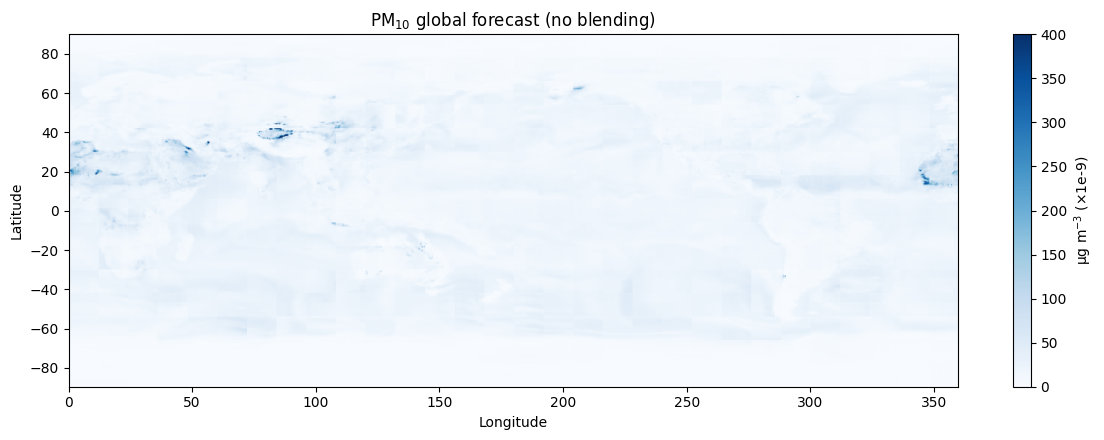

In [1]:
# --- Aurora tiled global PM10 (CPU) — no feather/weighted blending -----------
import pickle, gc
from pathlib import Path

import numpy as np
import torch
import xarray as xr
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

from aurora import Batch, Metadata, AuroraAirPollution

# ------------------ config / paths ------------------
download_path = Path("~/downloads/cams").expanduser()
surf_path = download_path / "2022-06-11-cams-surface-level.nc"
atmo_path = download_path / "2022-06-11-cams-atmospheric.nc"
static_path = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")

# ------------------ load static vars ------------------
with open(static_path, "rb") as f:
    static_vars_full = pickle.load(f)

# ------------------ open datasets ------------------
surf_ds = xr.open_dataset(surf_path, engine="netcdf4", decode_timedelta=True)
atmo_ds = xr.open_dataset(atmo_path, engine="netcdf4", decode_timedelta=True)
print("Surface dataset variables:", list(surf_ds.data_vars))
print("Atmospheric dataset variables:", list(atmo_ds.data_vars))

print("before forecast period selection:")
print("Surface dataset dims:", surf_ds.dims)
print("Atmospheric dataset dims:", atmo_ds.dims)
print("Surface dataset sizes:", surf_ds.sizes)
print("Atmospheric dataset sizes:", atmo_ds.sizes)
print("Surface dataset coords:", list(surf_ds.coords))
print("Atmospheric dataset coords:", list(atmo_ds.coords))
print(f"surf_ds.longitude.shape: {surf_ds.longitude.shape}, surf_ds.latitude.shape: {surf_ds.latitude.shape}")
print(f"atmo_ds.longitude.shape: {atmo_ds.longitude.shape}, atmo_ds.latitude.shape: {atmo_ds.latitude.shape}")

# use analysis product; keep both time steps (00Z, 12Z)
print("after forecast period selection:")
if "forecast_period" in surf_ds.dims: surf_ds = surf_ds.isel(forecast_period=0)
if "forecast_period" in atmo_ds.dims: atmo_ds = atmo_ds.isel(forecast_period=0)
print("Surface dataset dims:", surf_ds.dims)
print("Atmospheric dataset dims:", atmo_ds.dims)
print("Surface dataset sizes:", surf_ds.sizes)
print("Atmospheric dataset sizes:", atmo_ds.sizes)
print("Surface dataset coords:", list(surf_ds.coords))
print("Atmospheric dataset coords:", list(atmo_ds.coords))
print(f"surf_ds.longitude.shape: {surf_ds.longitude.shape}, surf_ds.latitude.shape: {surf_ds.latitude.shape}")
print(f"atmo_ds.longitude.shape: {atmo_ds.longitude.shape}, atmo_ds.latitude.shape: {atmo_ds.latitude.shape}")

# ------------------ build model ------------------
model = AuroraAirPollution()
model.load_checkpoint("microsoft/aurora", "aurora-0.4-air-pollution.ckpt")
model.eval()
ps = int(model.patch_size)
print("patch_size:", ps)

# ------------------ sizes & crop to multiples of patch size ------------------
lat_len = surf_ds.sizes["latitude"]
lon_len = surf_ds.sizes["longitude"]
H = (lat_len // ps) * ps
W = (lon_len // ps) * ps
print(f"Original dataset size (HxW): {lat_len} x {lon_len}")
print(f"Global working size (HxW): {H} x {W}")

print(f"before cropping surf_ds.latitude.shape: {surf_ds.latitude.shape}, surf_ds.longitude.shape: {surf_ds.longitude.shape}")
surf_ds = surf_ds.isel(latitude=slice(0, H), longitude=slice(0, W))
atmo_ds = atmo_ds.isel(latitude=slice(0, H), longitude=slice(0, W))
print(f"after cropping surf_ds.latitude.shape: {surf_ds.latitude.shape}, surf_ds.longitude.shape: {surf_ds.longitude.shape}")

lat_vec_full = atmo_ds.latitude.values
lon_vec_full = atmo_ds.longitude.values
print("lat_vec_full.shape:", lat_vec_full.shape)
print("lon_vec_full.shape:", lon_vec_full.shape)

# ------------------ tiling parameters ------------------
tile   = 12 * ps         # tile height/width
overlap = 2 * ps         # still define overlap for stride; no feathering used
step   = tile - overlap  # stride

# simple canvas to paste tiles (no weighted accumulation)
canvas = np.full((H, W), np.nan, dtype=np.float32)

def subset_static_tile(arr, ii, jj):
    if arr.ndim == 3:  # (C,H,W)
        return arr[:, ii, jj]
    if arr.ndim == 2:  # (H,W)
        return arr[ii, jj]
    return arr

# ------------------ run tiled inference (no blending) ------------------
gc.collect(); torch.cuda.empty_cache()

for i in range(0, H, step):
    for j in range(0, W, step):
        hi = min(i + tile, H)
        wi = min(j + tile, W)
        # force each side to be a multiple of ps
        h = (hi - i) // ps * ps
        w = (wi - j) // ps * ps
        if h < ps or w < ps:
            continue
        ii = slice(i, i + h)
        jj = slice(j, j + w)

        # build tile datasets
        surf_t = surf_ds.isel(latitude=ii, longitude=jj)
        atmo_t = atmo_ds.isel(latitude=ii, longitude=jj)
        static_vars_tile = {k: subset_static_tile(v, ii, jj) for k, v in static_vars_full.items()}

        surf_vars = {
            "2t":    torch.from_numpy(surf_t["t2m" ].values[None]),
            "10u":   torch.from_numpy(surf_t["u10" ].values[None]),
            "10v":   torch.from_numpy(surf_t["v10" ].values[None]),
            "msl":   torch.from_numpy(surf_t["msl" ].values[None]),
            "pm1":   torch.from_numpy(surf_t["pm1" ].values[None]),
            "pm2p5": torch.from_numpy(surf_t["pm2p5"].values[None]),
            "pm10":  torch.from_numpy(surf_t["pm10"].values[None]),
            "tcco":  torch.from_numpy(surf_t["tcco"].values[None]),
            "tc_no": torch.from_numpy(surf_t["tc_no"].values[None]),
            "tcno2": torch.from_numpy(surf_t["tcno2"].values[None]),
            "gtco3": torch.from_numpy(surf_t["gtco3"].values[None]),
            "tcso2": torch.from_numpy(surf_t["tcso2"].values[None]),
        }
        atmos_vars = {
            "t":   torch.from_numpy(atmo_t["t" ].values[None]),
            "u":   torch.from_numpy(atmo_t["u" ].values[None]),
            "v":   torch.from_numpy(atmo_t["v" ].values[None]),
            "q":   torch.from_numpy(atmo_t["q" ].values[None]),
            "z":   torch.from_numpy(atmo_t["z" ].values[None]),
            "co":  torch.from_numpy(atmo_t["co"].values[None]),
            "no":  torch.from_numpy(atmo_t["no"].values[None]),
            "no2": torch.from_numpy(atmo_t["no2"].values[None]),
            "go3": torch.from_numpy(atmo_t["go3"].values[None]),
            "so2": torch.from_numpy(atmo_t["so2"].values[None]),
        }

        batch_tile = Batch(
            surf_vars=surf_vars,
            static_vars={k: torch.from_numpy(v) for k, v in static_vars_tile.items()},
            atmos_vars=atmos_vars,
            metadata=Metadata(
                lat=torch.from_numpy(atmo_t.latitude.values),
                lon=torch.from_numpy(atmo_t.longitude.values),
                time=tuple(atmo_t.valid_time.values.astype("datetime64[s]").astype(object)),
                atmos_levels=tuple(int(x) for x in atmo_t.pressure_level.values),
            ),
        )

        with torch.inference_mode():
            pred_t = model(batch_tile)

        tile_pm10 = pred_t.surf_vars["pm10"][0, 0].cpu().numpy().astype(np.float32)

        # paste directly into the canvas (no weighting / feathering)
        canvas[ii, jj] = tile_pm10

        # free
        del surf_t, atmo_t, static_vars_tile, batch_tile, pred_t, tile_pm10
        gc.collect()

# ------------------ plot stitched map ------------------
pm10_disp = canvas / 1e-9  # µg m^-3 (×1e-9), for display

lat_plot = lat_vec_full.copy()
if lat_plot[0] > lat_plot[-1]:
    lat_plot = lat_plot[::-1]
    pm10_disp = pm10_disp[::-1, :]

extent = [lon_vec_full.min(), lon_vec_full.max(), lat_plot.min(), lat_plot.max()]

finite = np.isfinite(pm10_disp)
vmin, vmax = np.percentile(pm10_disp[finite], [5, 95])  # or fix to (0,400) if you prefer

plt.figure(figsize=(12, 4.5))
plt.imshow(pm10_disp, extent=extent, origin="lower",
           cmap="Blues", interpolation="bilinear",
           vmin=0, vmax=400, aspect="auto")
plt.title("PM$_{10}$ global forecast (no blending)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.colorbar(label="µg m$^{-3}$ (×1e-9)")
plt.tight_layout()
plt.show()
